### Visualization of metrics evolution with scarp diffusion

Authors: Alba M. Rodriguez Padilla and Mindy Zuckerman

In [29]:
%load_ext autoreload
%autoreload 2

# First, import a few Python packages and landlab tools
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.rcParams['font.size'] = 10
import utils
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load analysis outputs from csv file

In [30]:
excel_filename = "Code output csv/information_loss_analysis_outputs.csv"
data = pd.read_csv(excel_filename)

### Plot degradation coefficient and line length change over time

We define the degradation coefficient $\phi$ as:

\begin{equation}

\phi = \frac{slope_{t0 68th}}{slope_{t 68th}}

\end{equation}

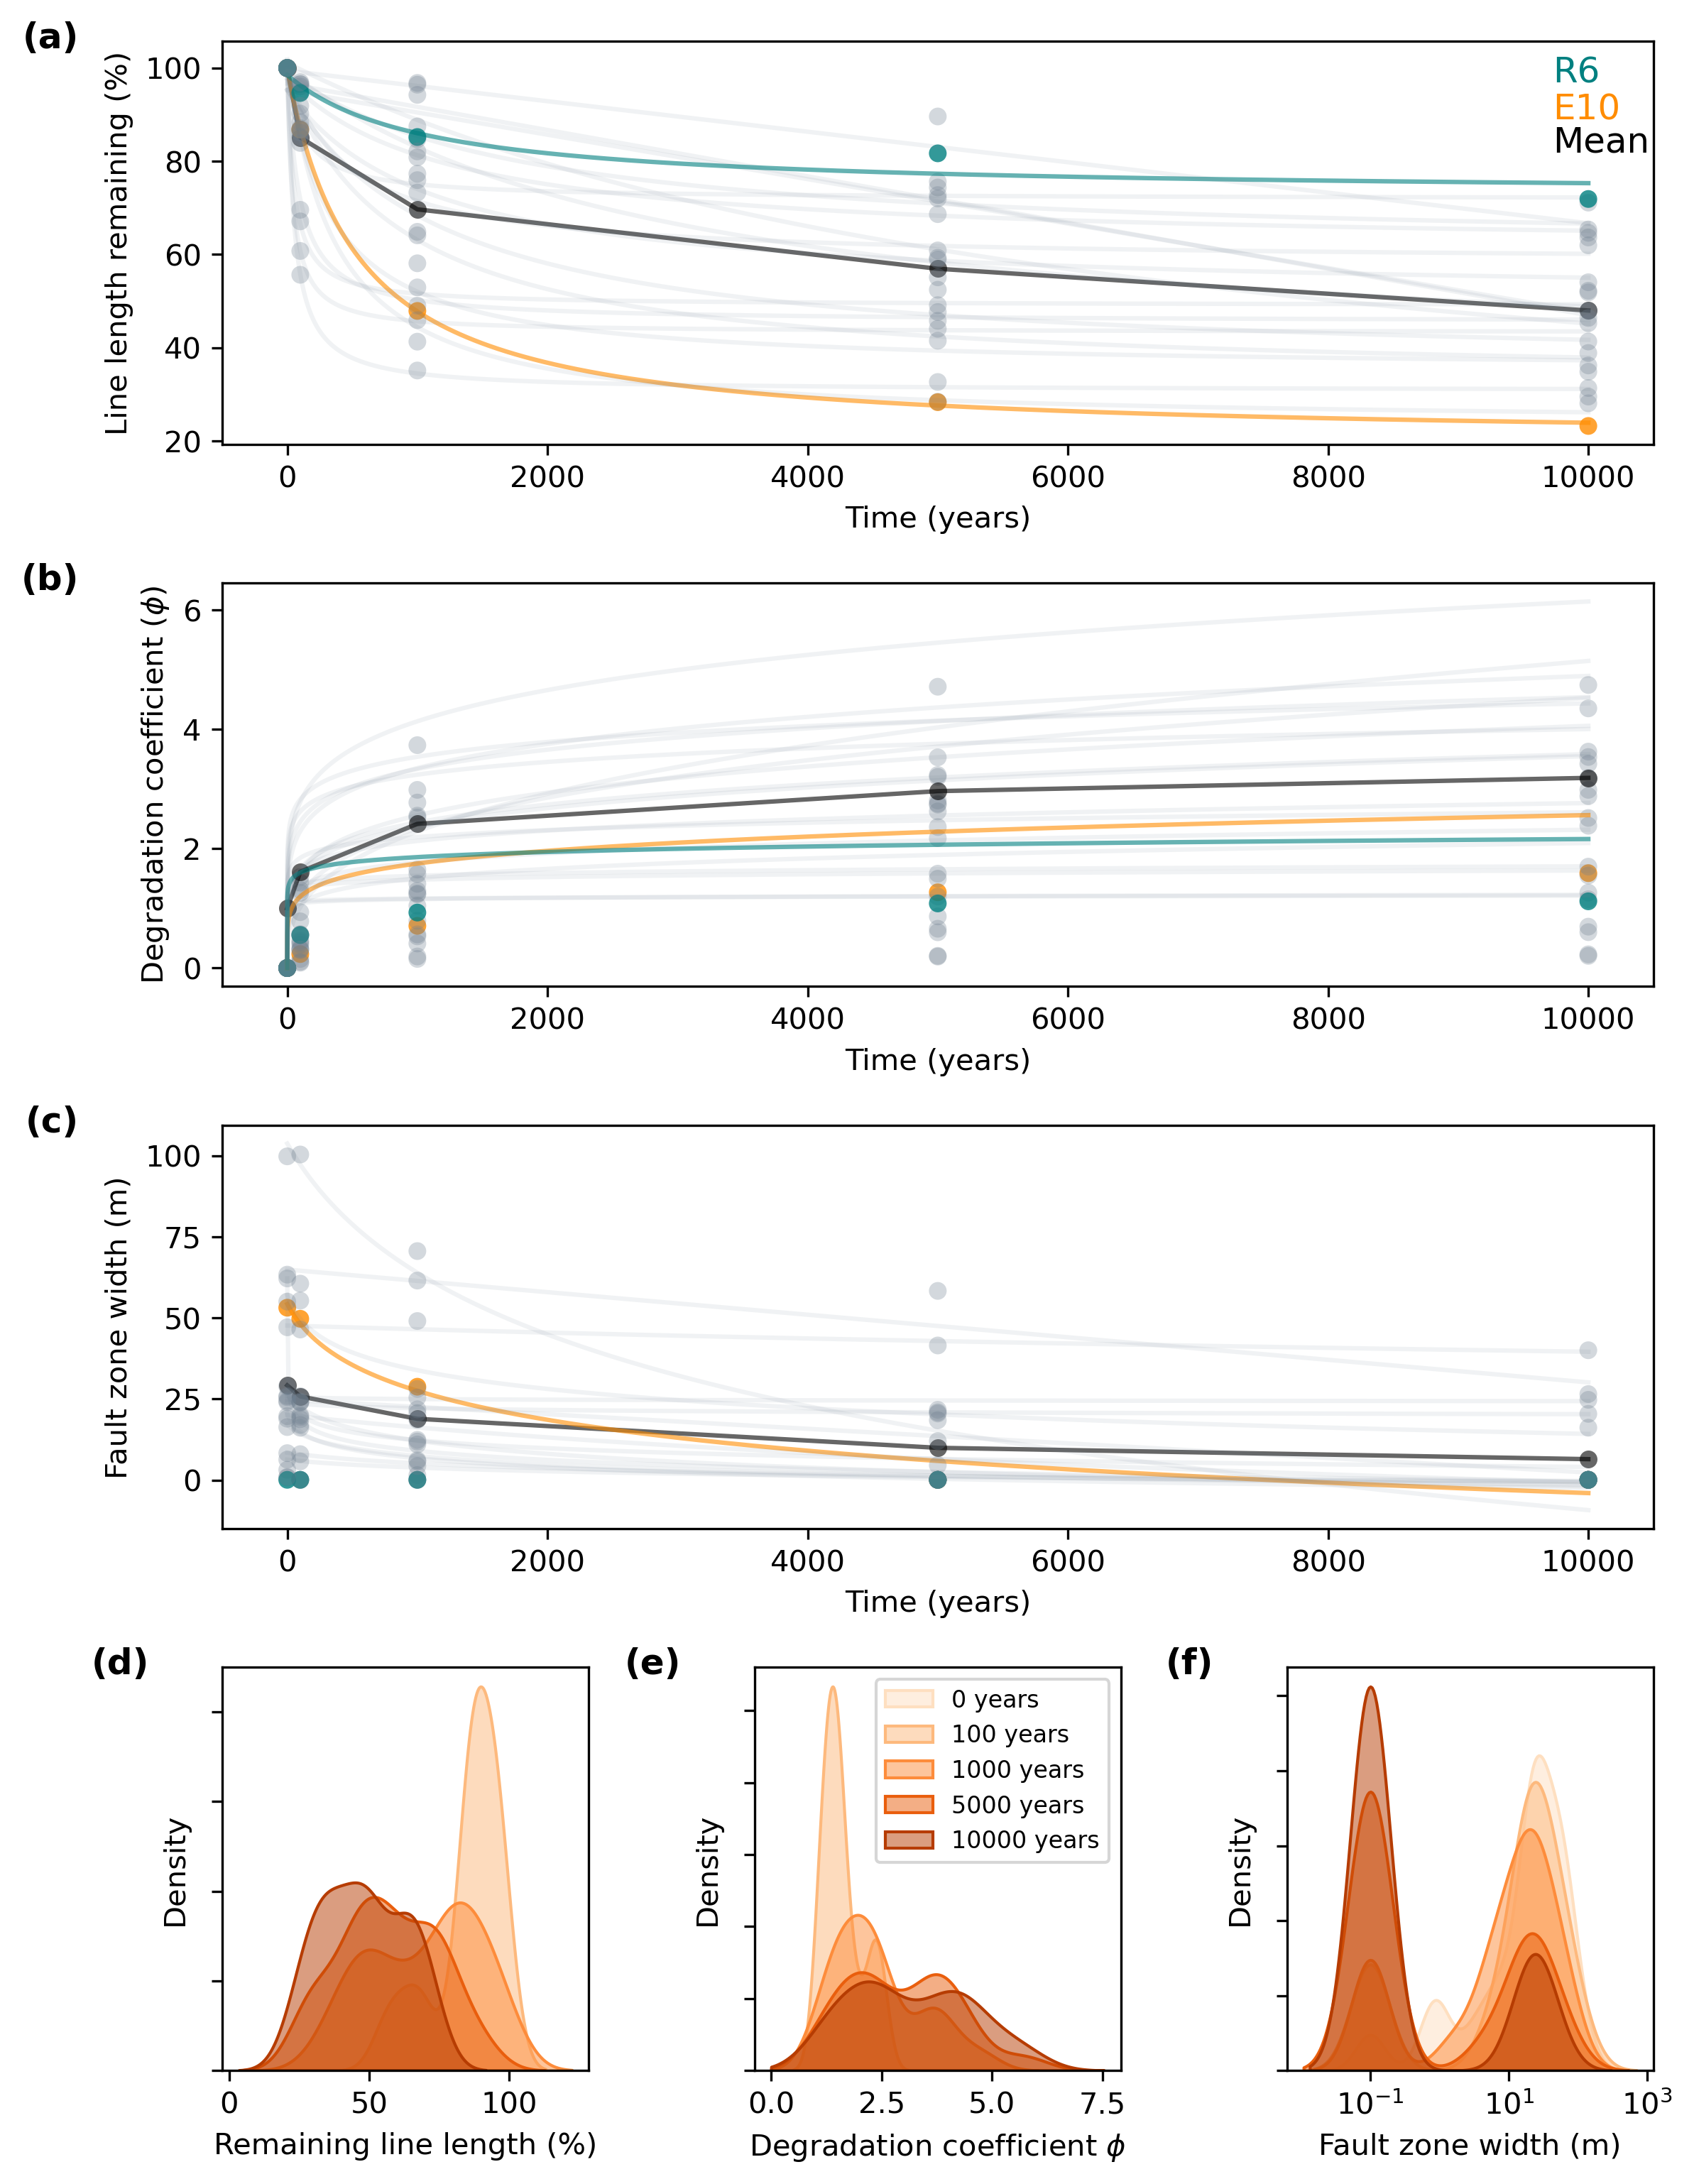

In [ ]:
grouped = data.groupby("DEM ID")

fig = plt.figure(figsize=(8, 15), dpi=300)
gs = fig.add_gridspec(6, 3, height_ratios=[1, 1, 1, 1, 1, 1])
ax_deg = fig.add_subplot(gs[1, :])  # Degradation coefficient plot
ax_length = fig.add_subplot(gs[0, :])  # Length remaining plot
ax_width = fig.add_subplot(gs[2, :])  # Width remaining plot
ax_small1 = fig.add_subplot(gs[3, 0])  # Distribution of length remaining
ax_small2 = fig.add_subplot(gs[3, 2])  # Distribution of degradation coefficient
ax_small3 = fig.add_subplot(gs[3, 1])  # Distribution of width remaining

#  degradation coefficient over time
for name, group in grouped:
    if name == "E10":
        col = "darkorange"
        alph = 0.8
    elif name == "R6":
        col = "teal"
        alph = 0.8
    else:
        col = "slategray"
        alph = 0.3

    ax_deg.scatter(
        group["Time (years)"],
        group["Degradation coefficient"],
        c=col,
        alpha=alph,
        edgecolor="none",
    )
    popt_deg, pcov_deg = curve_fit(
        utils.func_deg_coeff, group["Time (years)"], group["Degradation coefficient"]
    )
    x = np.linspace(min(group["Time (years)"]), max(group["Time (years)"]), 10000)
    ax_deg.plot(x, utils.func_deg_coeff(x, *popt_deg), c=col, alpha=alph - 0.2)

ax_deg.set_ylabel("Degradation coefficient ($\phi$)", fontsize=10)
ax_deg.set_xlabel("Time (years)", fontsize=10)

#  normalized line length over time
for name, group in grouped:
    normalized_length = group["Length (m)"] / group["Length (m)"].iloc[0]
    if name == "E10":
        col = "darkorange"
        alph = 0.8
    elif name == "R6":
        col = "teal"
        alph = 0.8
    else:
        col = "slategray"
        alph = 0.3

    ax_length.scatter(
        group["Time (years)"],
        normalized_length * 100,
        c=col,
        alpha=alph,
        edgecolor="none",
        zorder=2,
    )

    popt_line, pcov_line = curve_fit(
        utils.func_line_length, group["Time (years)"], normalized_length
    )
    x = np.linspace(min(group["Time (years)"]), max(group["Time (years)"]), 10000)
    ax_length.plot(
        x, utils.func_line_length(x, *popt_line) * 100, color=col, alpha=alph - 0.2
    )

ax_length.set_ylabel("Line length remaining (%)", fontsize=10)
ax_length.set_xlabel("Time (years)", fontsize=10)

# normalized length
length_at_time_zero = (
    data[data["Time (years)"] == 0.0].set_index("DEM ID")["Length (m)"].to_dict()
)


def normalize_length(row):
    return row["Length (m)"] / length_at_time_zero[row["DEM ID"]]


data["Normalized length"] = data.apply(normalize_length, axis=1)

ax_length.text(9725, 89, "E10", c="darkorange", fontsize=12)
ax_length.text(9725, 97, "R6", c="teal", fontsize=12)
ax_length.text(9725, 82, "Mean", c="black", fontsize=12)


# width remaining over time
for name, group in grouped:
    if group["Width (m)"].iloc[0] != 0.1:
        normalized_width = group["Width (m)"] / group["Width (m)"].iloc[0]
    else:
        normalized_width = group["Width (m)"]
    if name == "E10":
        col = "darkorange"
        alph = 0.8
    elif name == "R6":
        col = "teal"
        alph = 0.8
    else:
        col = "slategray"
        alph = 0.3

    ax_width.scatter(
        group["Time (years)"],
        group["Width (m)"],
        c=col,
        alpha=alph,
        edgecolor="none",
        zorder=2,
    )

    # Skip fitting if width is always 0.1 (no evolution)
    time_data = group["Time (years)"].values
    width_data = group["Width (m)"].values
    
    if not np.allclose(width_data, 0.1):
        try:
            # a: initial width, b: growth rate coefficient, c: time scale parameter
            initial_width = width_data[0] if len(width_data) > 0 else 0.1
            max_time = np.max(time_data) if len(time_data) > 1 else 10000.0
            final_width = width_data[-1] if len(width_data) > 1 else initial_width * 2
            
            # For a + b * log(1 + x/c), estimate b and c
            width_change = final_width - initial_width
            log_factor = np.log(1 + max_time / 1000.0)  # Assume 1000 year time scale initially
            growth_rate = width_change / log_factor if log_factor > 0 else 1.0
            time_scale = max_time / 10.0  # Start with time scale being 1/10 of data range
            
            p0 = [initial_width, growth_rate, time_scale]

            popt_width, pcov_width = curve_fit(
                utils.func_width_evolution, time_data, width_data, 
                p0=p0, maxfev=2000
            )
            x = np.linspace(min(time_data), max(time_data), 1000)
            ax_width.plot(
                x, utils.func_width_evolution(x, *popt_width), color=col, alpha=alph - 0.2
            )
        except:
            # if fitting fails, don't plot the fit line, applies to rare cases when width increases with erosion
            pass

ax_width.set_ylabel("Fault zone width (m)", fontsize=10)
ax_width.set_xlabel("Time (years)", fontsize=10)

grouped = data.groupby("Time (years)")
palette = sns.color_palette("Oranges", len(grouped))

for i, (key, group) in enumerate(grouped):
    color = palette[i]
    sns.kdeplot(
        group["Normalized length"] * 100,
        ax=ax_small1,
        fill=True,
        alpha=0.5,
        clip=(1e-5, None),
        bw_adjust=0.8,
        color=color,
    )

    sns.kdeplot(
        group["Width (m)"],
        ax=ax_small2,
        label=f"{int(key)} years",
        fill=True,
        alpha=0.5,
        bw_adjust=0.5,
        color=color,
        log_scale=True,
    )
    ax_small2.set_xscale("log")

    sns.kdeplot(
        group["Degradation coefficient"],
        ax=ax_small3,
        fill=True,
        alpha=0.5,
        clip=(1e-5, None),
        bw_adjust=0.8,
        color=color,
    )

# add meansto show overall trend
time_steps = sorted(data["Time (years)"].unique())
mean_lengths = []
mean_widths = []
mean_degs = []

for time in time_steps:
    time_data = data[data["Time (years)"] == time]
    mean_lengths.append(
        np.mean(time_data["Normalized length"]) * 100
    ) 
    mean_widths.append(np.mean(time_data["Width (m)"]))
    mean_degs.append(np.mean(time_data["Degradation coefficient"]))

ax_length.plot(time_steps, mean_lengths, "o-", color="black", markeredgecolor="none", alpha=0.6, zorder=1)
ax_width.plot(time_steps, mean_widths, "o-", color="black", markeredgecolor="none", alpha=0.6, zorder=1)
ax_deg.plot(time_steps, mean_degs, "o-", color="black", markeredgecolor="none", alpha=0.6, zorder=1)


ax_small1.set_xlabel("Remaining line length (%)")
ax_small2.set_xlabel("Fault zone width (m)")
ax_small3.set_xlabel(f"Degradation coefficient $\phi$")

#  legend from ax_small2 and display it on ax_small3
handles, labels = ax_small2.get_legend_handles_labels()
ax_small3.legend(handles, labels, fontsize=8)
ax_small1.set_yticklabels([])
ax_small2.set_yticklabels([])
ax_small3.set_yticklabels([])

ax_length.text(
    -0.1,
    1.05,
    "(a)",
    transform=ax_length.transAxes,
    fontsize=12,
    fontweight="bold",
    va="top",
    ha="right",
)
ax_deg.text(
    -0.1,
    1.05,
    "(b)",
    transform=ax_deg.transAxes,
    fontsize=12,
    fontweight="bold",
    va="top",
    ha="right",
)
ax_width.text(
    -0.1,
    1.05,
    "(c)",
    transform=ax_width.transAxes,
    fontsize=12,
    fontweight="bold",
    va="top",
    ha="right",
)
ax_small1.text(
    -0.2,
    1.05,
    "(d)",
    transform=ax_small1.transAxes,
    fontsize=12,
    fontweight="bold",
    va="top",
    ha="right",
)
ax_small2.text(
    -0.2,
    1.05,
    "(f)",
    transform=ax_small2.transAxes,
    fontsize=12,
    fontweight="bold",
    va="top",
    ha="right",
)
ax_small3.text(
    -0.2,
    1.05,
    "(e)",
    transform=ax_small3.transAxes,
    fontsize=12,
    fontweight="bold",
    va="top",
    ha="right",
)

plt.tight_layout()
plt.savefig("Figures/deg_coeff_L_evolution.png", bbox_inches="tight")